### Add images to CSV BBOX

In [5]:
import os
import pandas as pd
import glob

def find_image_name(row, image_dict):
    """
    Construct the image name based on row's id and frame_number,
    then check if it exists in the image_dict.
    """
    id_frame_pattern = f"img_{int(row['id'])}_{int(row['frame_number'])}"
    matched_images = [img for img in image_dict.get(int(row['id']), []) if id_frame_pattern in img]
    return matched_images[0] if matched_images else None

def append_image_names(csv_path, base_path):
    # Load the CSV into a DataFrame
    df = pd.read_csv(csv_path, dtype={'id': 'int64','frame_number': 'int64'})

    # Dictionary to hold image names for each id
    image_dict = {}

    # List directories in the base path and filter by those matching the ids in the DataFrame
    for dir_name in os.listdir(base_path):
        dir_path = os.path.join(base_path, dir_name)
        if os.path.isdir(dir_path) and dir_name.isdigit():
            id = int(dir_name)
            # List all images for the current id
            image_dict[id] = [os.path.basename(x) for x in glob.glob(os.path.join(dir_path, "*.png"))]

    # Apply the function to find the matching image name for each row
    df['img_name'] = df.apply(lambda row: find_image_name(row, image_dict), axis=1)
    
    return df


BASE_IMAGEES_PATH = '/home/diego/Documents/yolov7-tracker/imgs_conce'
BASE_FOLDER_NAME = 'logs'
CSV_FILE_PATH = 'conce_bbox.csv'

CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, CSV_FILE_PATH)
updated_df = append_image_names(CSV_FILE_PATH, BASE_IMAGEES_PATH)

updated_df.to_csv(CSV_FILE_PATH, index=False)

### Add kfold to images and add label_img, label_direction column

In [6]:
# Re-importing necessary libraries and redefining the function with corrections
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
import os
# Re-defining the set_folds function
def set_folds(csv_path, k_folds, n_images):
    df = pd.read_csv(csv_path)

    # Ensure 'img_name' column exists
    if 'img_name' not in df.columns:
        raise ValueError("img_name column doesn't exist in the dataset.")

    # Initialize k_fold column in original df
    df['k_fold'] = np.nan
    df['label_img'] = np.nan
    df['label_direction'] = np.nan

    # Filter rows where 'img_name' is not empty
    df_filtered = df[df['img_name'] != ''].copy()

    # Sort by 'id' and 'frame_number'
    df_filtered.sort_values(by=['id', 'frame_number'], inplace=True)

    # Process each ID separately in filtered df
    for id_value in df_filtered['id'].unique():
        subset = df_filtered[(df_filtered['id'] == id_value) & (df_filtered['img_name'].notna())]

        # Apply KFold or assign all to the same fold if condition is met
        if len(subset) < k_folds * n_images:
            df.loc[subset.index, 'k_fold'] = 0  # Assign all to fold 0 if condition is met
        else:
            # Apply KFold
            kf = KFold(n_splits=k_folds)
            for fold, (_, test_index) in enumerate(kf.split(subset)):
                # Select n_images per fold if specified
                #selected_indices = test_index[:n_images] if n_images < len(test_index) else test_index Selecciona los primeros n_images
                selected_indices = np.random.choice(test_index, min(n_images, len(test_index)), replace=False)
                df.loc[subset.iloc[selected_indices].index, 'k_fold'] = fold
                df.loc[subset.iloc[selected_indices].index, 'label_img'] = 0
    return df

BASE_FOLDER_NAME = 'logs'
CSV_FILE_PATH = 'conce_bbox.csv'
CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, CSV_FILE_PATH)
df_with_folds = set_folds(CSV_FILE_PATH, k_folds=5, n_images=3)

df_with_folds.to_csv(CSV_FILE_PATH, index=False)


### CSV to SQL LITE

In [2]:
import pandas as pd
import sqlite3
import os

def convert_csv_to_sqlite(csv_file_path, db_file_path, table_name='bbox_data'):
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file_path)
    
    # Create a connection to the SQLite database
    conn = sqlite3.connect(db_file_path)
    
    # Write the data to a SQLite table
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    
    # Close the connection
    conn.close()

BASE_FOLDER_NAME = 'logs'
CSV_FILE_PATH = 'conce_bbox.csv'

CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, CSV_FILE_PATH)

db_file_path = f'{BASE_FOLDER_NAME}/bbox_data.db'
convert_csv_to_sqlite(CSV_FILE_PATH, db_file_path)

### SQLite -> CSV

In [4]:
import pandas as pd
import sqlite3
import os

def convert_sqlite_to_csv(db_file_path, csv_file_path, table_name='bbox_data'):
    # Create a connection to the SQLite database
    conn = sqlite3.connect(db_file_path)
    
    # Read the table into a pandas DataFrame
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    
    # Write the DataFrame to a CSV file
    df.to_csv(csv_file_path, index=False)
    
    # Close the connection
    conn.close()

BASE_FOLDER_NAME = 'logs'

db_file_path = f'{BASE_FOLDER_NAME}/bbox_data.db'
CSV_FILE_PATH = 'converted_bbox.csv'
CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, CSV_FILE_PATH)

convert_sqlite_to_csv(db_file_path, CSV_FILE_PATH)

### Model Image Selection

In [27]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


BASE_FOLDER_NAME = 'logs'
CSV_FILE_NAME = 'converted_bbox.csv'
CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, CSV_FILE_NAME)


MODEL_RESULT = os.path.join(BASE_FOLDER_NAME, f'model_img_selction{CSV_FILE_NAME}')



INTEREST_LABEL = 'label_img'
interest_values = [1, 2]  # Define the values you're interested in BAD and GOOD images


# Load your data
df = pd.read_csv(CSV_FILE_PATH)

# Preprocess your data
df[INTEREST_LABEL] = df[INTEREST_LABEL].apply(lambda x: x if x in interest_values else None).astype(float)


# Further filter the DataFrame to only include rows with ID lower than 1300 for training
train_df = df[(df['id'] < 1300) & df[INTEREST_LABEL].notna()]

# For prediction, you'd consider rows beyond ID 1300 or those not fitting the interest labels
predict_df = df[(df['id'] >= 1300) | df[INTEREST_LABEL].isna()]

#Filter only the rows that has img_name
predict_df = predict_df.dropna(subset=['img_name'])

# Define features and target
features = ['area', 'centroid_x', 'centroid_y', 'frame_number', 'overlap', 'distance_to_center', 'conf_score']
target = INTEREST_LABEL

# Splitting the training data for validation
X_train, X_val, y_train, y_val = train_test_split(train_df[features], train_df[target], test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Validate the model
val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy}")

# Predicting on the dataset without labels
predict_features = predict_df[features]
predicted_labels = model.predict(predict_features)
predicted_confidences = model.predict_proba(predict_features).max(axis=1)

# Adding predictions back to the dataframe
predict_df['model_label_img'] = predicted_labels
predict_df['model_label_conf'] = predicted_confidences

# Combine the prediction and training dataframes
final_df = pd.concat([train_df, predict_df], sort=False)

# Save the updated dataframe to a new CSV file
final_df.to_csv(MODEL_RESULT, index=False) #-> SAVE

print("Updated CSV saved successfully.")
### OJO DIEGO ###
# Este resultado se le quitan todas las rows que no tienen img_name

/tmp/ipykernel_8110/4239801089.py:25: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_FILE_PATH)


Validation Accuracy: 0.900990099009901
Updated CSV saved successfully.


### Model Image Selection Test

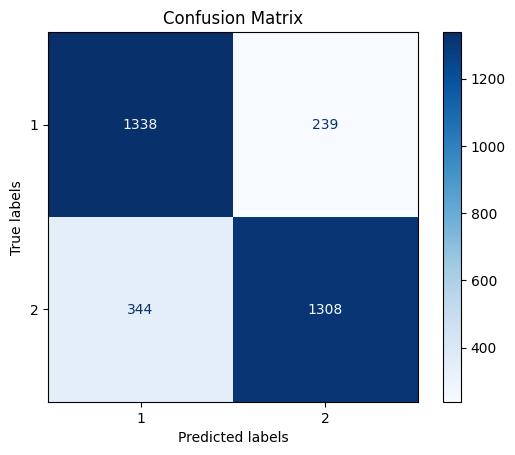

Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.85      0.82      1577
           2       0.85      0.79      0.82      1652

    accuracy                           0.82      3229
   macro avg       0.82      0.82      0.82      3229
weighted avg       0.82      0.82      0.82      3229



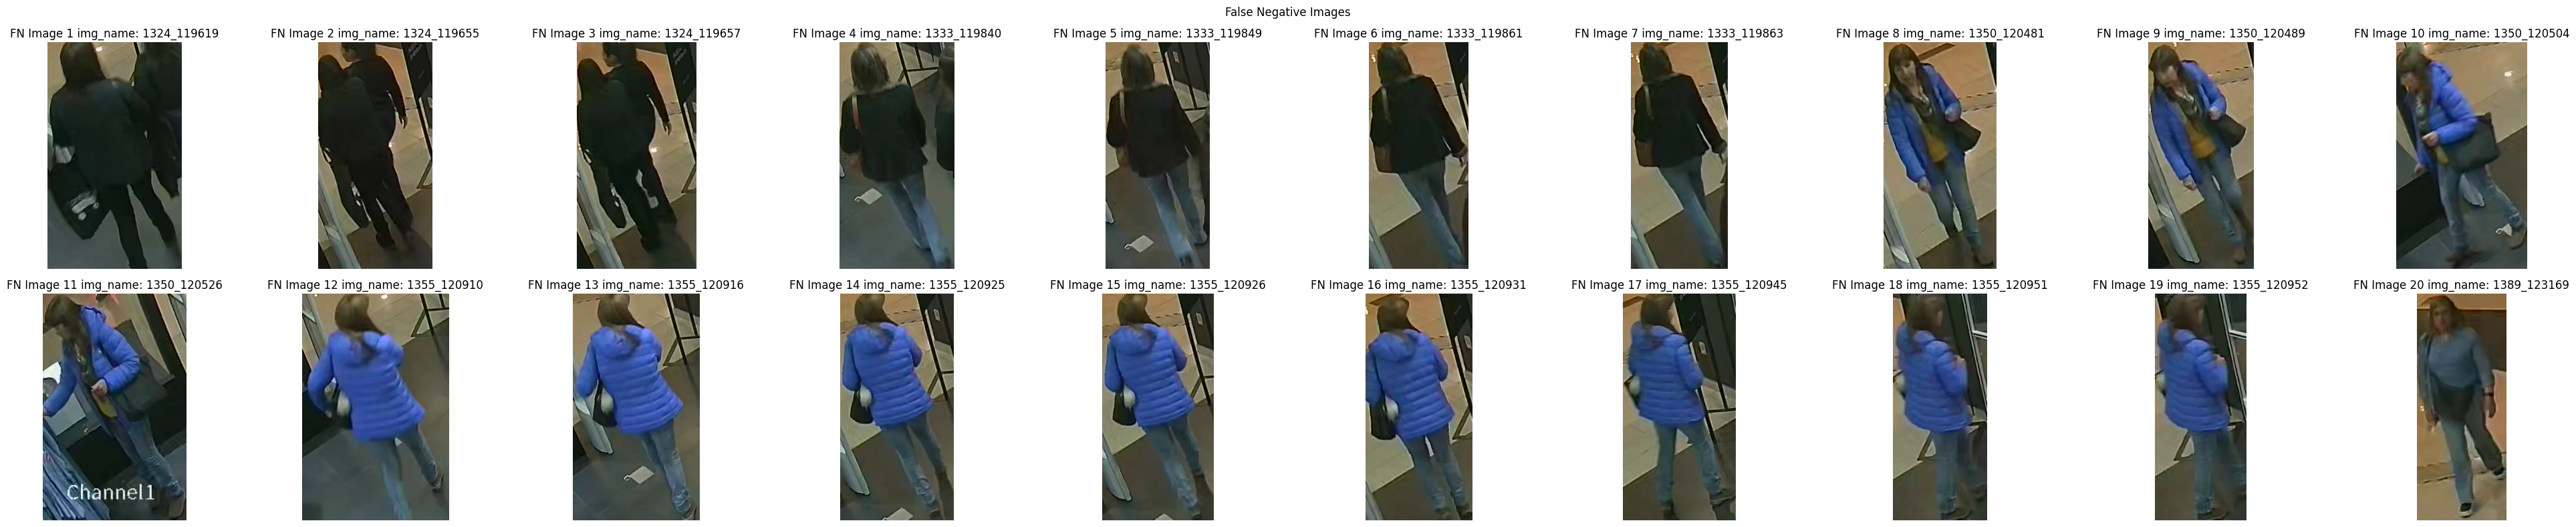

In [28]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
FOLDER_PATH_IMGS = '/home/diego/Documents/yolov7-tracker/imgs_conce/'


# Filter final_df to include only rows where both 'model_label_img' and INTEREST_LABEL are not null
comparison_df = final_df.dropna(subset=['model_label_img', INTEREST_LABEL])
# Extract model predictions and actual labels
y_pred = comparison_df['model_label_img']
y_true = comparison_df[INTEREST_LABEL]

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
cmd = ConfusionMatrixDisplay(cm, display_labels=interest_values)
cmd.plot(cmap="Blues")
cmd.ax_.set(xlabel='Predicted labels', ylabel='True labels', title='Confusion Matrix')
plt.show()

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=[str(label) for label in interest_values])

print("Classification Report:")
print(report)

# Assuming 'comparison_df' contains the actual (INTEREST_LABEL) and predicted ('model_label_img') labels
# Let's identify False Negatives: actual label is in interest_values, but predicted is not.
total_wrong_filter = (comparison_df[INTEREST_LABEL].isin(interest_values)) & (comparison_df['model_label_img'] != comparison_df[INTEREST_LABEL])
false_negative_filter = (comparison_df[INTEREST_LABEL] == 1) & (comparison_df['model_label_img'] == 2) # False Negative filter
false_positive_filter = (comparison_df[INTEREST_LABEL] == 2) & (comparison_df['model_label_img'] == 1) # False Positive filter

false_negatives = comparison_df[false_negative_filter]

# Assuming 'img_name' column exists and contains the path to images
fn_images = false_negatives['img_name'].tolist()[:20]

# Define the grid size for plotting
n_rows = 2  # Adjust based on the number of images you want per column
n_cols = (len(fn_images) + 1) // n_rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
fig.suptitle('False Negative Images')

# Flatten the axes array for easy indexing
axes = axes.flatten()

for i, img_name in enumerate(fn_images):
    img_path = os.path.join(FOLDER_PATH_IMGS,img_name.split('_')[1], img_name)
    img = mpimg.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f'FN Image {i+1} img_name: {img_name.split("_")[1]}_{img_name.split("_")[2]}')
    axes[i].axis('off')

# Hide any empty subplots
for j in range(i + 1, n_rows * n_cols):
    axes[j].axis('off')

plt.tight_layout()
# Save the figure to disk
save_path = 'logs/imageSelectionResults.png'  # Specify your desired path and filename
plt.savefig(save_path, dpi=300)  # Adjust DPI for higher resolution images
plt.show()

### TEST Show model results predictions [Deprecated]

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from PIL import Image
# import os
# import random

# # Read the CSV file
# BASE_FOLDER_NAME = 'logs'
# CSV_FILE_PATH = 'updated_conce_bbox_area.csv'
# NEW_CSV = os.path.join(BASE_FOLDER_NAME, 'updated_conce_bbox_area_model.csv')

# def find_matching_file_path(directory, filename_start):
#     """
#     Searches for files in the specified directory that start with the given filename start string.
    
#     :param directory: The directory to search within.
#     :param filename_start: The initial part of the file name to match.
#     :return: The full path to the first matching file, or None if no match is found.
#     """
#     # Construct the search pattern
#     search_pattern = os.path.join(directory, filename_start + "*.png")
    
#     # Use glob to find all files matching the pattern
#     matching_files = glob.glob(search_pattern)
    
#     # Return the first matching file path, if any
#     if matching_files:
#         return matching_files[0]  # Return full path of the first match
#     else:
#         return ''  # No match found

# df = pd.read_csv(NEW_CSV)

# # Filter rows where `model_label` and `model_confidence` are not null
# df_filtered = df.dropna(subset=['model_label', 'model_confidence'])

# # Filtering rows where frame_number % 3 == 0
# #df_filtered = df_filtered[df_filtered['frame_number'] % 3 == 0]

# # Base path for the images
# base_path = "/home/diego/Documents/yolov7-tracker/imgs_conce"

# # Function to construct the file path
# def construct_file_path(row):
#     return os.path.join(base_path, str(int(row['id'])))

# # Apply the function to construct file paths
# df_filtered['file_path'] = df_filtered.apply(construct_file_path, axis=1)

# # Randomly select 50 images if available, or take the whole dataset if less than 50
# sample_size = min(20, len(df_filtered))
# sampled_df = df_filtered.sample(n=sample_size)

# rows = (sample_size + 4) // 5  # Calculate rows needed for the sample size, adjust the denominator to change columns
# cols = 5 if sample_size > 5 else sample_size  # Adjust columns based on sample size

# fig, axs = plt.subplots(rows, cols, figsize=(20, 8 * rows))  # Adjust figsize dynamically
# axs = axs.flatten()  # Flatten to easily loop over if it's a grid

# for i in range(len(axs)):
#     if i < sample_size:
#         row = sampled_df.iloc[i]
#         img_path = find_matching_file_path(row.file_path, f"img_{row.id}_{row.frame_number}")
#         if os.path.exists(img_path):
#             img = Image.open(img_path)
#             axs[i].imshow(img)
#             axs[i].set_title(f"ID: {row.id}\nFrame: {row.frame_number}\nLabel: {int(row.model_label)}\nConfidence: {row.model_confidence:.2f}", fontsize=10)
#             axs[i].axis('off')
#         else:
#             axs[i].set_visible(False)
#     else:
#         axs[i].set_visible(False)  # Hide unused subplots

# plt.tight_layout()
# plt.show()


### Data process IN/OUT/BAD Feature Engineering

In [6]:
import pandas as pd
import os
import numpy as np

BASE_FOLDER_NAME = 'logs'
CSV_FILE_PATH = 'converted_bbox.csv'
CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, CSV_FILE_PATH)

# Load your data
df = pd.read_csv(CSV_FILE_PATH)

# Ensure the DataFrame is sorted by 'id' and 'frame_number' for correct diff calculations
df.sort_values(by=['id', 'frame_number'], inplace=True)

# Calculate Movement Features (Δx and Δy)
df['delta_x'] = df.groupby('id')['centroid_x'].diff().fillna(0)
df['delta_y'] = df.groupby('id')['centroid_y'].diff().fillna(0)

# Calculate Aggregated Features for each ID
aggregations = {
    'delta_x': ['mean', 'max', 'min', 'std'],
    'delta_y': ['mean', 'max', 'min', 'std']
}
aggregated_features = df.groupby('id').agg(aggregations).reset_index()

# Correct the naming of the aggregated columns
aggregated_features.columns = ['id'] + [f'{var}_{stat}' for var, stats in aggregations.items() for stat in stats]

# Correctly merge aggregated features back to the original dataframe
df = pd.merge(df, aggregated_features, on='id', how='left')

# Calculate Sequence Features (net movement direction)
df['net_movement_x'] = df.groupby('id')['delta_x'].transform('sum')
df['net_movement_y'] = df.groupby('id')['delta_y'].transform('sum')

df.to_csv(CSV_FILE_PATH, index=False)

print("Updated CSV saved successfully.")

/tmp/ipykernel_8110/4124090662.py:10: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_FILE_PATH)


Updated CSV saved successfully.


### In vs Out

In [24]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

BASE_FOLDER_NAME = 'logs'
CSV_FILE_NAME = 'converted_bbox.csv'
CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, CSV_FILE_NAME)
INTEREST_LABEL = 'label_direction'
NEW_FILE = 'updated_conce_bbox_with_predictions.csv'

MODEL_RESULT = os.path.join(BASE_FOLDER_NAME, f'model_inout_{CSV_FILE_NAME}')

# Load the data
df = pd.read_csv(CSV_FILE_PATH)

# DIEGO
# df = df.dropna(subset=['img_name','k_fold','label_img']) -> No combiene, xq estoy perdiendo data para training

# columns_to_drop = ['img_name', 'k_fold', 'label_img']
# df = df.drop(columns=columns_to_drop,axis=1)  -> Tambien pierdo data en columnas

# Filter out rows with 'BAD' or empty in 'label_direction'
df = df[(df[INTEREST_LABEL] == 'IN') | (df[INTEREST_LABEL] == 'OUT')] # FUNCIONA


train_df = df[(df['id'] < 1300) & (df[INTEREST_LABEL] == 'IN') | (df[INTEREST_LABEL] == 'OUT')]
predict_df = df[(df['id'] >= 1300) | ~((df[INTEREST_LABEL] == 'IN') | (df[INTEREST_LABEL] == 'OUT'))]



# Correctly encode 'IN' as 1 and 'OUT' as 0
label_encoder = LabelEncoder()
df['label_direction_encoded'] = label_encoder.fit_transform(df[INTEREST_LABEL])  # 'IN' -> 1, 'OUT' -> 0

not_imporant_features = ['id', INTEREST_LABEL, 'label_direction_encoded','conf_score','k_fold','label_img','overlap','area','frame_number']
# Define features (make sure to only include numeric columns and exclude any text columns)
features = [col for col in df.columns if col not in not_imporant_features and df[col].dtype in [np.int64, np.float64]]
target = 'label_direction_encoded'

# Split the data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
val_predictions = model.predict(X_val)
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy}")




predict_df = predict_df.dropna(subset=features)
# Predicting on the dataset without labels
predict_features = predict_df[features]
predicted_labels = model.predict(predict_features)
predicted_confidences = model.predict_proba(predict_features).max(axis=1)

# Adding predictions back to the dataframe
predict_df['model_label_direction'] = predicted_labels
predict_df['model_label_direction_conf'] = predicted_confidences

# Combine the prediction and training dataframes
final_df = pd.concat([train_df, predict_df], sort=False)

# Save the updated dataframe to a new CSV file
final_df.to_csv(MODEL_RESULT, index=False) 

print("Updated CSV saved successfully.")










# prediction_probs_D = model.predict_proba(X_val)[:, 1]  # Probability of being 'IN'
# prediction_probs2_D = model.predict_proba(X_val)



# # Prepare the entire dataset for prediction
# # First, ensure only numeric features are used
# df['model_label_direction'] = np.nan  # Initialize column for model predictions
# df['model_label_direction_conf'] = np.nan  # Initialize column for prediction confidence

# # Predicting on rows needing prediction (assuming 'BAD' or not labeled)
# predict_features = df[features]
# df['model_label_direction'] = model.predict(predict_features)
# df['model_label_direction_conf'] = model.predict_proba(predict_features)[:, 1]  # Probability of being 'IN'

# # Mapping numeric predictions back to 'IN' or 'OUT'
# df['model_label_direction'] = label_encoder.inverse_transform(df['model_label_direction'].astype(int))

# # Save the updated dataframe to a new CSV file
# NEW_CSV_PATH = os.path.join(BASE_FOLDER_NAME, NEW_FILE)
# df.to_csv(NEW_CSV_PATH, index=False)

# print("Updated CSV with predictions saved successfully.")


/tmp/ipykernel_8110/542086831.py:18: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_FILE_PATH)
/tmp/ipykernel_8110/542086831.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['label_direction_encoded'] = label_encoder.fit_transform(df_filtered[INTEREST_LABEL])  # 'IN' -> 1, 'OUT' -> 0


Validation Accuracy: 1.0
Updated CSV saved successfully.


### In|OUT vs BAD

In [20]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

BASE_FOLDER_NAME = 'logs'
CSV_FILE_PATH = 'conce_bbox.csv_alternative.csv'
CSV_FILE_PATH = os.path.join(BASE_FOLDER_NAME, CSV_FILE_PATH)

# Load the original data
df_original = pd.read_csv(CSV_FILE_PATH)

# Create a copy for processing
df = df_original.copy()

# Encode labels: 1 for 'IN' or 'OUT' (good image), 0 for 'BAD' (bad image), keep NaN for now
df['label_encoded'] = df['label_direction'].apply(lambda x: 1 if x in ['IN', 'OUT'] else 0 if x == 'BAD' else np.nan)

# Prepare data for model training (exclude rows with NaN in 'label_encoded')
df_train = df.dropna(subset=['label_encoded'])

# Define features (excluding non-numeric columns and the 'label_direction', 'label_encoded' columns)
features = [col for col in df_train.columns if col not in ['id', 'label_direction', 'label_encoded'] and df_train[col].dtype in [np.int64, np.float64]]
target = 'label_encoded'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_train[features], df_train[target], test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict on the entire original dataset (make sure to handle NaNs in features if they exist)
df_original['label_good_dir'] = model.predict(df_original[features].fillna(0))  # Using fillna(0) as an example handling method
df_original['label_good_dir_conf'] = model.predict_proba(df_original[features].fillna(0))[:, 1]  # Confidence of being a good image

# Save the updated dataframe with predictions for the entire dataset to a new CSV file
NEW_CSV_PATH = os.path.join(BASE_FOLDER_NAME, 'updated_conce_bbox_with_good_dir_predictions.csv')
df_original.to_csv(NEW_CSV_PATH, index=False)

print("Updated CSV with good direction predictions saved successfully.")


/tmp/ipykernel_12258/3214391915.py:13: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original = pd.read_csv(CSV_FILE_PATH)


Updated CSV with good direction predictions saved successfully.
